# Simulation of the physical sistem

## Functions

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from QUBO import QMatrix, QUBOSolution
from qutip import *
import networkx as nx
import dwave_networkx as dnx
import itertools
import minorminer as mm
from scipy import interpolate
from itertools import combinations
from collections import defaultdict
from graphs import DrawSolution, NetworkToFile, FileToNetwork
from graphs import DrawNetwork, GraphPartitioning, RandomGraphGenerator

In [2]:
#Initial Hamiltonian
def makeInitialHamiltonian(N):
    '''
    Returns the initial Hamiltonian

    Parameters
    ----------
    N  : int
         dimension of the graph
                
    Output
    ------
    Hi  :  array
           initial Hamiltonian
    '''
            
    sx = sigmax()
    identity = qeye(2)
    
    sx_list = []
    
    for n in range(N):
        aux_list = []
        for m in range(N):
            aux_list.append(identity)
    
        aux_list[n] = sx
        sx_list.append(tensor(aux_list))
    
    Hi = 0
    for item in sx_list:
        Hi += item
    
    return np.array(-Hi)

In [3]:
#QUBO Hamiltonian
def makeQUBOHamiltonian(fileName, alpha, beta):
    '''
    Returns the QUBO problem Hamiltonian for a given graph

    Parameters
    ----------
    fileName  : string
                name of the file containing the graph
    alpha     : double
                weight balancing constraint for the Q matrix
    beta      : double
                weight balancing constraint for the Q matrix
                
    Output
    ------
    Hp  :  array
           QUBO problem Hamiltonian
    '''
    
    #Graph
    G = FileToNetwork(fileName)
    n = nx.number_of_nodes(G)
    m = nx.number_of_edges(G)
    
    #Computing the Q matrix
    Q = np.zeros((n,n))

    for u, v  in G.edges:
        node_u = min(u,v)
        node_v = max(u,v)
    
        Q[node_u,node_u] += 1*beta
        Q[node_v,node_v] += 1*beta
        Q[node_u,node_v] += -2*beta
 
    for i in G.nodes:
        Q[i,i] += alpha*(1-n)

    for i, j in combinations(G.nodes, 2):
        node_i = min(i,j)
        node_j = max(i,j)
        Q[node_i,node_j] += 2*alpha
    
    
    #Hamiltonian
    dim = pow(2, len(Q))
    H = np.zeros(dim)
    Hp = np.zeros((dim, dim), dtype=complex)
    
    state = [0 for i in range(len(Q))]
      
    #for k in range(dim):
        #for i in range(len(Q)):
            #H[k] += Q[i][i]*state[i]
        #for j in range(i):
            #H[k] += Q[i][j]*state[i]*state[j]
    
        #nextState(state)
    for k in range(dim):
        H[k] = np.matmul(state, np.matmul(Q, state))
        nextState(state)
        
    for k in range(dim):
        Hp[k][k] = H[k]
        
    return H, Hp  

In [4]:
#QUBO Physical Hamiltonian
def makePhysicalHamiltonian(source, target, embedding, alpha, beta, RCS):
    '''
    Returns the QUBO problem Hamiltonian for a given graph

    Parameters
    ----------
    source      : networkx graph
                  source graph
    target      : networkx graph
                  target graph
    embedding   : dictionary
                  minor embedding from the source graph to the target graph
    alpha       : double
                  weight balancing constraint for the Q matrix
    beta        : double
                  weight balancing constraint for the Q matrix
    RCS         : double
                  RCS value
    
    Output
    ------
    H, Hp  :  array
              QUBO problem Hamiltonians
    '''
    
    #Graph (logical)
    n = nx.number_of_nodes(source)
    m = nx.number_of_edges(source)
    
    #Qubits used in physical system (physical graph)
    physical_nodes = []
    for vertex in embedding:
        for node in embedding[vertex]:
            physical_nodes.append(node)
    num_physical_qubits = len(physical_nodes)
    
    used_graph = target.subgraph(physical_nodes)   
    

    #Logical parameters
    Q = np.zeros((n,n))

    for u, v in source.edges:
        node_u = min(u,v)
        node_v = max(u,v)
    
        Q[node_u,node_u] += 1*beta
        Q[node_v,node_v] += 1*beta
        Q[node_u,node_v] += -2*beta
 
    for i in source.nodes:
        Q[i,i] += alpha*(1-n)

    for i, j in combinations(source.nodes, 2):
        node_i = min(i,j)
        node_j = max(i,j)
        Q[node_i,node_j] += 2*alpha
    
    #Physical parameters
    Qp = defaultdict(int)
    
    for i in source.nodes:
        chain_length = float(len(embedding[i]))
        for node in embedding[i]:
            Qp[(node, node)] = Q[i,i]/chain_length
        
    for i in source.nodes:
        for j in range(i):
            number_of_connections = 0
            for node_i in embedding[i]:
                for node_j in used_graph.neighbors(node_i):
                    if node_j in embedding[j]:
                        number_of_connections +=1
            for node_i in embedding[i]:
                for node_j in used_graph.neighbors(node_i):
                    if  node_j in embedding[j]:
                        u =  min(node_i, node_j)
                        v =  max(node_i, node_j)
                        Qp[(u,v)] = Q[j,i]/number_of_connections   
        
    max_val = np.abs(np.amax(Q))
    min_val = np.abs(np.amin(Q)) 
    chain_strength = max(max_val, min_val)*RCS
 
    
    for i in source.nodes:
        chain = used_graph.subgraph(embedding[i])
        chain_edges = list(chain.edges)
        for edge in chain_edges:
            u =  min(edge)
            v =  max(edge)
        
            Qp[(u,v)] = -4*chain_strength
            Qp[(u,u)] += 2*chain_strength
            Qp[(v,v)] += 2*chain_strength
            
    Qp_matrix = np.zeros((num_physical_qubits, num_physical_qubits))
    for label1, label2 in Qp:
        i = physical_nodes.index(label1)
        j = physical_nodes.index(label2)
        node1 = min(i,j)
        node2 = max(i,j)
        
        Qp_matrix[node1][node2] = Qp[(label1, label2)]
        
     
    #Hamiltonian
    dim = pow(2, num_physical_qubits)
    H = np.zeros(dim)
    Hp = np.zeros((dim, dim), dtype=complex)
    
    state = [0 for i in range(num_physical_qubits)]
    
    for k in range(dim):
        H[k] = np.matmul(state, np.matmul(Qp_matrix, state))
        nextState(state)
        
    #for k in range(dim):
        #for i in range(len(physical_nodes)):
            #H[k] += Qp[(physical_nodes[i],physical_nodes[i])]*state[i]
            #for j in range(i):
                #H[k] += Qp[(physical_nodes[j],physical_nodes[i])]*state[i]*state[j]
        #nextState(state)
        
    for k in range(dim):
        Hp[k][k] = H[k]
      
    return H, Hp

In [5]:
def nextState(state):
    '''
    Modifies a given QUBO state into a new one
    
    Parameters
    ----------
    state  : array
             state of the QUBO Hamiltonian
    '''
    
    n = len(state) - 1
    aux = False
    
    while not (aux):
        
        if (state[n] == 0):
            aux = True
            break
        
        n -= 1
        if (n < 0):
            break
    
    state[n] = 1
    n += 1
    while (n < len(state)):
        state[n] = 0
        n +=1

In [6]:
def groundState(H):
    '''
    Computes the ground states of a given diagonal Hamiltonian
    
    Parameters
    ----------
    H  : array
         given Hamiltonian
         
    Output
    ------
    gs  : list
          position of the ground states
          
    '''
    
    aux = H[0]
    
    for i in range(len(H)):
        if(H[i] < aux):
            aux = H[i]
    
    gs = []
    
    for i in range(len(H)):
        if (np.absolute(H[i]-aux) < 0.001):
            gs.append(i)
        
    return gs

In [7]:
def path(fileName):
    '''
    Returns the annealing path functions
    
    Parameters
    ----------
    fileName  : string
                name of the file containing the functions
    
    Output
    ------
    A  : array
         values of A(s)
    B  : array
         values of B(s)
    '''
    
    vecA = np.zeros(1000)
    vecB = np.zeros(1000)
    s = np.zeros(1000)
    i = 0
    
    with open(fileName) as file:
        for line in file:
            info =  line.split()
            s[i] = float(info[0])
            vecA[i] = np.pi*float(info[1])
            vecB[i] = np.pi*float(info[2])
            i +=1
            
    A = interpolate.interp1d(s, vecA, kind = "quadratic")
    B = interpolate.interp1d(s, vecB, kind = "quadratic")
    
    return A, B

In [8]:
def CrankNicolson(H, psi, delta_t):
    '''
    Crank-Nicolson algorithm for the time evolution of the wavefunction

    Input
    -----
    H        : array
               Hamiltonian of the system
    psi      : array
               wave function at t
    delta_t  : double
               time increase
    
    Output
    ------
    psi  : array
           wave function at t + delta_t
    '''
    dim = len(H)
    
    M = np.identity(dim, dtype=complex) - (0. + 1.j)*delta_t/2*H
    Minv = np.linalg.inv(np.identity(dim, dtype=complex) + (0. + 1.j)*delta_t/2*H)
    
    psi = np.matmul(M, psi)
    psi = np.matmul(Minv, psi)
    
    return psi

In [116]:
def evolutionAB_IG(Hi, Hp, A, B, tf, delta_t, gs):
    '''
    Calculates the evolution of the system and the overlap with instantaneous ground state 
    

    Input
    -----
    Hi          : array
                  initial Hamiltonian
    Hp          : array
                  problem Hamiltonian
    A           : interpolate function
    B           : interpolate function
    tf          : float
                  maximum annealing time
    delta_t     : double
                  time increase
    Output
    ------
    overlap  : list
               overlap with instantaneous ground state
    '''
    
    overlap = []
    t = 0
    degeneracy = len(gs)
    
    vap, vep = np.linalg.eigh(A(t/tf)*Hi + B(t/tf)*Hp)
    mod = 0
    psi = vep[:,0]
    
    for i in range(degeneracy):
        psi0 = vep[:,i]
        psi0 = np.conjugate(psi0)
        prod = np.dot(psi,psi0)
        mod += (np.real(prod)*np.real(prod) + np.imag(prod)*np.imag(prod))
    
    overlap.append(mod)
        
    while (t < tf):
        
        H = A(t/tf)*Hi + B(t/tf)*Hp
            
        psi = CrankNicolson(H, psi, delta_t)
        t += delta_t
            
        vap, vep = np.linalg.eigh(H)
        mod = 0
            
        for j in range(degeneracy):
            psi0 = vep[:, j]
            psi0 = np.conjugate(psi0)
            prod = np.dot(psi,psi0)
            mod += (np.real(prod)*np.real(prod) + np.imag(prod)*np.imag(prod))
            
        overlap.append(mod)
    
    return overlap

In [86]:
def evolutionABTargetPhysical(target_H, Hi, Hp, A, B, tf, delta_t, gs, chain):
    '''
    Calculates the evolution of the system and the overlap with target ground state 
    

    Input
    -----
    target_H    : array
                  target matrix
    Hi          : array
                  initial Hamiltonian
    Hp          : array
                  problem Hamiltonian
    A           : interpolate function
    B           : interpolate function
    tf          : float
                  maximum annealing time
    delta_t     : double
                  time increase
    chain       : array
                  indices of chained nodes
    Output
    ------
    overlap  : list
               overlap with target ground state
    '''
    
    overlap = []
    t = 0
    degeneracy = len(gs)
    
    vap, vep = np.linalg.eigh(target_H)
    psi_target = []
    for i in range(degeneracy):
        psi_target.append(vep[:, i])

    target_binary = []
    for i in range(len(psi_target)):
        target_binary.append(toBinary(4,psi_target[i]))
    
    for i in range(len(psi_target)):
        target_binary[i] = np.insert(target_binary[i], chain, [target_binary[i][chain[0]], target_binary[i][chain[1]]])
    
    psi_target_physical = []
    for i in range(len(target_binary)):
        psi_target_physical.append(toTensor(6, tuple(target_binary[i])))
    
   
    H = A(t/tf)*Hi + B(t/tf)*Hp
    
    vap, vep = np.linalg.eigh(H)
    mod = 0
    psi = vep[:,0]
    
    for i in range(degeneracy):
        psi0 = psi_target_physical[i]
        psi0 = np.conjugate(psi0)
        prod = np.dot(psi,psi0)
        mod += (np.real(prod)*np.real(prod) + np.imag(prod)*np.imag(prod))
    
    overlap.append(mod)
        
    while (t < tf):
        
        H = A(t/tf)*Hi + B(t/tf)*Hp
            
        psi = CrankNicolson(H, psi, delta_t)
        t += delta_t
            
        mod = 0
            
        for j in range(degeneracy):
            psi0 = psi_target_physical[j]
            psi0 = np.conjugate(psi0)
            prod = np.dot(psi,psi0)
            mod += (np.real(prod)*np.real(prod) + np.imag(prod)*np.imag(prod))
            
        overlap.append(mod)
    
    return overlap

In [10]:
def toBinary(n, state):
    '''
    Transforms a tensor product state into a binary state
    
    Parameters
    ----------
    n      : int
             number of qubits
    state  : array
             tensor product state
    
    Output
    ------
    binary_state  : array
                    binary state of n qubits
    
    '''
    
    dim = pow(2, n)
    states = itertools.product([0,1], repeat = n)
    states = list(states)
    states_list= []

    for i in range(dim):
        states_list.append(states[i])
        
    index = np.where(state == 1)
    index  = index[0][0]
    
    binary_state = states_list[-index-1]
    
    return binary_state

In [11]:
def toTensor(n, state):
    '''
    Transforms a tensor product state into a binary state
    
    Parameters
    ----------
    n      : int
             number of qubits
    state  : array
             binary state
    
    Output
    ------
    tensor_state  : array
                    tensor state of n qubits
    
    '''
    
    dim = pow(2, n)
    states = itertools.product([0,1], repeat = n)
    states = list(states)
    states_list= []

    for i in range(dim):
        states_list.append(states[i]) 
        
    index = states_list.index(state)
    
    tensor_state = np.zeros(dim)
    tensor_state[dim-1-index] = 1
    
    
    return tensor_state

In [12]:
def chainBreak(n, state, chains):
    '''
    Returns false if there is a chain break or true if not.
    
    Parameters
    ----------
    n       : int
              number of qubits
    state   : array
              state to check 
    chains  : array
              indices of chained qubits        
    '''
    
    binary_state = toBinary(n, state)
    aux = False

    for i in range(len(chains)):
        i1 = chains[i][0]
        i2 = chains[i][1]
        
        if (binary_state[i1] != binary_state[i2]):
            aux = True
         
       
                
    return aux
    

In [13]:
def physicalToLogical(n, state, chains):
    '''
    Returns the logical state of a given set of states
    
    Parameters
    ----------
    n       : int
              number of qubits
    state   : array
              state to be transformed
    chains  : array
              indices of chained qubits
              
    Output
    ------
    logical_state  : array
                     equivalent logical state
    '''
    
    breaks = False
    
    binary_state = toBinary(n, state)

    for i in range(len(chains)):
        i1 = chains[i][0]
        i2 = chains[i][1]
        
        if (binary_state[i1] != binary_state[i2]):
            breaks = True
            
    if (breaks == False):
        logical_state = toBinary(n, state)
        logical_state = list(logical_state)
            
        for j in range(len(chains)):
            i1 = chains[j][0]
            logical_state.pop(i1)
    else:
        logical_state = None
    
    return logical_state 

In [14]:
def QMatrix(G, alpha, beta):
    
    n = nx.number_of_nodes(G)
    
    #Computing the Q matrix
    Q = np.zeros((n,n))

    for u, v  in G.edges:
        node_u = min(u,v)
        node_v = max(u,v)
    
        Q[node_u,node_u] += 1*beta
        Q[node_v,node_v] += 1*beta
        Q[node_u,node_v] += -2*beta
 
    for i in G.nodes:
        Q[i,i] += alpha*(1-n)

    for i, j in combinations(G.nodes, 2):
        node_i = min(i,j)
        node_j = max(i,j)
        Q[node_i,node_j] += 2*alpha
    return Q

In [118]:
def checkResults(overlap1, overlap2, num_tf):
    results = []
    
    for i in range(num_tf):
        results.append(overlap1[i][0][-1]-overlap2[i][0][-1])
    return results       

## Logical graph

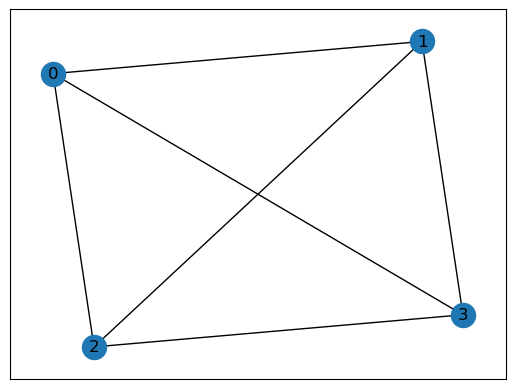

In [15]:
#Create the graph
G = FileToNetwork("graph3.txt")
DrawNetwork(G, "3.png")
n = nx.number_of_nodes(G)
m = nx.number_of_edges(G)

## Physical graph

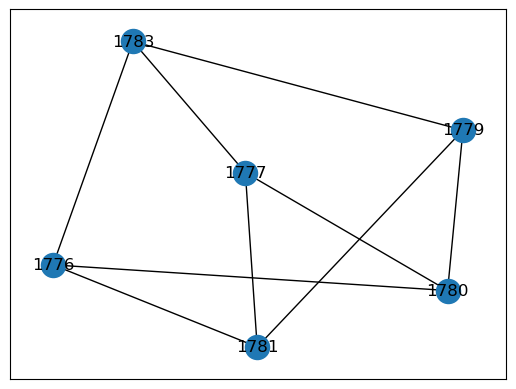

6


In [16]:
#Embedding
C = FileToNetwork("chimera.txt")
#embedding = mm.find_embedding(G, C)
embedding = {0: [1777, 1783], 1: [1779], 2: [1780], 3: [1776, 1781]}
num_physical_qubits = 0
physical_nodes = []
for vertex in embedding:
    for node in embedding[vertex]:
        physical_nodes.append(node)
        num_physical_qubits += 1
used_graph = C.subgraph(physical_nodes) 
DrawNetwork(used_graph, "embedding.png")
print(num_physical_qubits)

## Simulation for the physical system

In [84]:
#Parameters
min_RCS = 0.0
max_RCS = 1.0
num_RCS = 20
RCS = np.linspace(min_RCS, max_RCS, num_RCS)
min_tf = 2.5
max_tf = 10
num_tf = 5
tf = np.linspace(min_tf, max_tf, num_tf)
delta_t = 0.001
nodes = [0,3]
print(tf)

[ 2.5    4.375  6.25   8.125 10.   ]


In [85]:
#Functions
A, B = path("DW_2000Q_6.txt")

In [117]:
#Overlap (instantaneous ground state RCS = 0.5)
logical_Hp1, logical_Hp2 = makeQUBOHamiltonian("graph3.txt", 1.25, 1)
physical_Hp1, physical_Hp2 = makePhysicalHamiltonian(G, C, embedding, 1.25, 1, 0.5)
physical_Hi = makeInitialHamiltonian(num_physical_qubits)
gs = groundState(logical_Hp1)

overlap_IG_physical = []
for i in range(num_tf):
    overlap_IG_physical.append([])
    
for i in range(num_tf):
    
    t_f = tf[i]
    
    #Evolution
    overlap_IG_physical[i].append(evolutionAB_IG(physical_Hi, physical_Hp2, A, B, t_f, delta_t, gs)) 

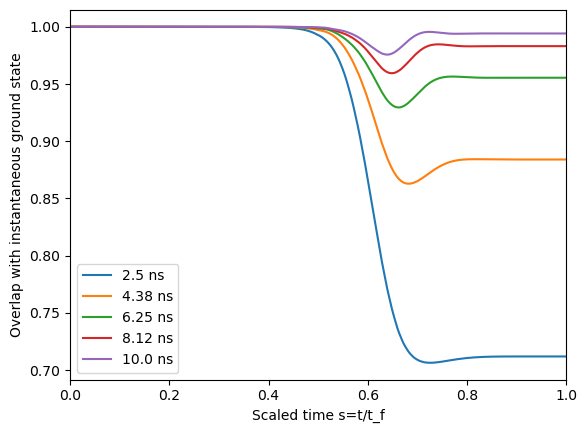

In [132]:
#Plot overlap with instantaneous ground state
plt.xlim([0, 1])
#plt.ylim([0, 1])
plt.xlabel("Scaled time s=t/t_f")
plt.ylabel("Overlap with instantaneous ground state")
for i in range(num_tf):
    x = np.linspace(0, 1, len(overlap_IG_physical[i][0]))
    name = str(round(tf[i],2)) + " ns"
    plt.plot(x, overlap_IG_physical[i][0], label = name)
    plt.legend()
plt.savefig("Overlap_IG(physical)_4.png")

In [87]:
#Overlap (target ground state RCS = 0.5)
logical_Hp1, logical_Hp2 = makeQUBOHamiltonian("graph3.txt", 1.25, 1)
physical_Hp1, physical_Hp2 = makePhysicalHamiltonian(G, C, embedding, 1.25, 1, 0.5)
physical_Hi = makeInitialHamiltonian(num_physical_qubits)
gs = groundState(logical_Hp1)

overlap_TG_physical = []
for i in range(num_tf):
    overlap_TG_physical.append([])
    
for i in range(num_tf):
    
    t_f = tf[i]
    
    #Evolution
    overlap_TG_physical[i].append(evolutionABTargetPhysical(logical_Hp2, physical_Hi, physical_Hp2, A, B, t_f, delta_t, gs, nodes)) 

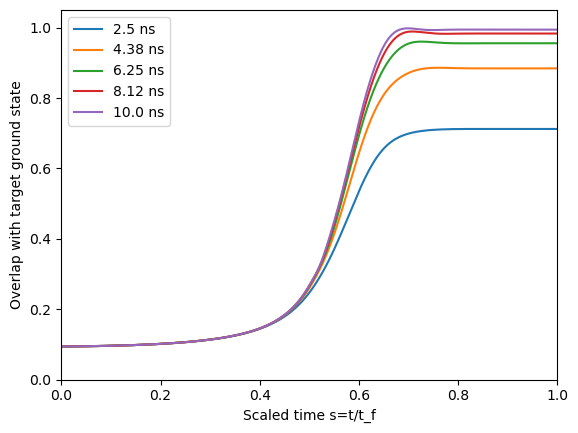

In [147]:
#Plot overlap with target ground state
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.xlabel("Scaled time s=t/t_f")
plt.ylabel("Overlap with target ground state")
for i in range(num_tf):
    x = np.linspace(0, 1, len(overlap_TG_physical[i][0]))
    name = str(round(tf[i],2)) + " ns"
    plt.plot(x, overlap_TG_physical[i][0], label = name)
    plt.legend()
plt.savefig("Overlap_TG(physical)_4.png")

In [124]:
print(checkResults(overlap_IG_physical, overlap_TG_physical, num_tf))

[8.14007909966108e-08, -7.986995509412509e-10, -4.267526587664605e-08, 7.711271288179944e-09, 1.4053678665248981e-08]


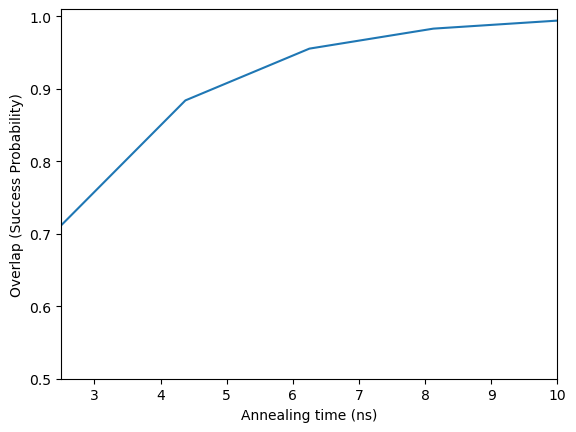

In [141]:
plt.xlim([min(tf), max(tf)])
plt.ylim([0.5, 1.01])
plt.xlabel("Annealing time (ns)")
plt.ylabel("Overlap (Success Probability)")
successProbability_physical = np.empty(num_tf)
for i in range(num_tf):
    successProbability_physical[i] = overlap_TG_physical[i][0][-1]
plt.plot(tf, successProbability_physical)
plt.savefig("Success_Probability_vs_Annealing_time_4(physical).png")

In [130]:
success = []
logical_Hp1, logical_Hp2 = makeQUBOHamiltonian("graph3.txt", 1.25, 1)
gs = groundState(logical_Hp1)

for i in range(num_tf):
    success.append([])
    
for i in range(num_RCS):
    physical_Hp1, physical_Hp2 = makePhysicalHamiltonian(G, C, embedding, 1.25, 1, RCS[i])
    physical_Hi = makeInitialHamiltonian(num_physical_qubits)
    
    for j in range(num_tf):
        t_f = tf[j]
        aux = evolutionABTargetPhysical(logical_Hp2, physical_Hi, physical_Hp2, A, B, t_f, delta_t, gs, nodes)
        success[j].append(aux[-1])

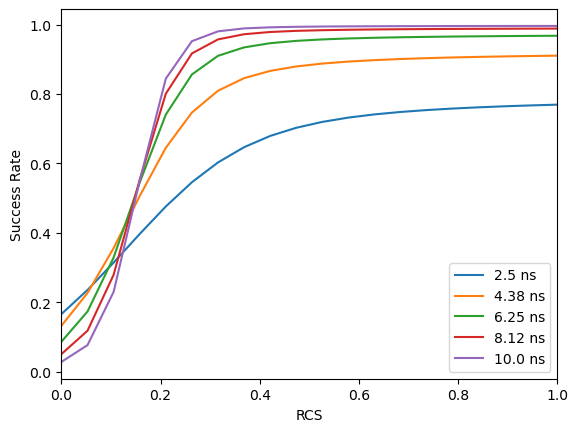

In [148]:
plt.xlim([0, max(RCS)])
#plt.ylim([-0.1, 1])
plt.xlabel("RCS")
plt.ylabel("Success Rate")
for i in range(num_tf):
    name = str(round(tf[i],2)) + " ns"
    plt.plot(RCS, success[i], label = name)
    plt.legend()
plt.savefig("Success_Probability_vs_RCS_4.png")

In [114]:
min_RCS = 0.0
max_RCS = 1.0
num_RCS = 20
RCS = np.linspace(min_RCS, max_RCS, num_RCS)

num_RCS2 = 100
RCS2 = np.linspace(min_RCS, max_RCS, num_RCS2)

success = []
logical_Hp1, logical_Hp2 = makeQUBOHamiltonian("graph3.txt", 1.25, 1)
gs = groundState(logical_Hp1)

for i in range(num_RCS2):
    physical_Hp1, physical_Hp2 = makePhysicalHamiltonian(G, C, embedding, 1.25, 1, RCS2[i])
    physical_Hi = makeInitialHamiltonian(num_physical_qubits)


    aux = evolutionABTargetPhysical(logical_Hp2, physical_Hi, physical_Hp2, A, B, 35 , delta_t, gs, nodes)
    success.append(aux[-1])
    
cut_edges_DW = np.empty(num_RCS)
success_rate = np.zeros(num_RCS)
deviation = np.zeros(num_RCS)

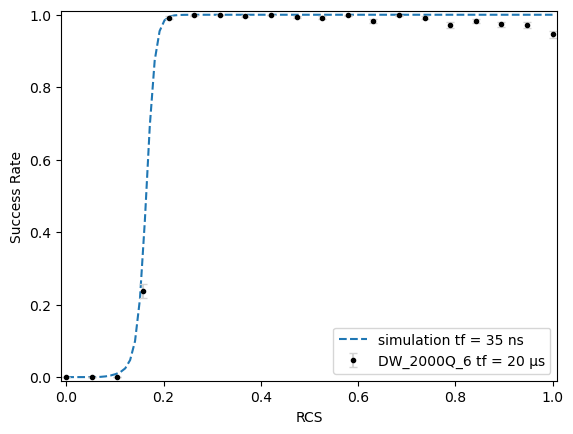

In [115]:
with open("DW-RCS-graph3.txt") as file:
    i = 0
    for line in file:
        info = line.split()
        success_rate[i] = float(info[1])
        deviation[i] = float(info[2])
        cut_edges_DW[i] = float(info[3])
        i += 1
plt.ylim([-0.01, 1.01])
plt.xlim([-0.01, 1.01])
plt.xlabel("RCS")
plt.ylabel("Success Rate")
plt.plot(RCS2, success, '--', label = "simulation tf = 35 ns")
plt.errorbar(RCS, success_rate, yerr = deviation, fmt='.', color='black', ecolor='lightgray', capsize = 3, label = "DW_2000Q_6 tf = 20 μs")
plt.legend()
plt.savefig("Success_Rate_vs_RCS(DW+sim)_35.png")

## Evolution

In [67]:
#Parameters
tf = 15
RCS = 0
delta_t = 0.001
chains = [[0,1], [4,5]]
nodes = [0,3]

In [68]:
#Functions
A, B = path("DW_2000Q_6.txt")

In [69]:
#Logical states list {(state) : [chain_break, energy, num_occurrences]}
logical = defaultdict(int)
states = itertools.product([0,1], repeat = 4)
states = list(states)
Q = QMatrix(G, 1.25, 1)

for i in range(len(states)):
    logical[states[i]] = [0, np.matmul(states[i], np.matmul(Q, states[i])), 0]
print(logical)

defaultdict(<class 'int'>, {(0, 0, 0, 0): [0, 0.0, 0], (0, 0, 0, 1): [0, -0.75, 0], (0, 0, 1, 0): [0, -0.75, 0], (0, 0, 1, 1): [0, -1.0, 0], (0, 1, 0, 0): [0, -0.75, 0], (0, 1, 0, 1): [0, -1.0, 0], (0, 1, 1, 0): [0, -1.0, 0], (0, 1, 1, 1): [0, -0.75, 0], (1, 0, 0, 0): [0, -0.75, 0], (1, 0, 0, 1): [0, -1.0, 0], (1, 0, 1, 0): [0, -1.0, 0], (1, 0, 1, 1): [0, -0.75, 0], (1, 1, 0, 0): [0, -1.0, 0], (1, 1, 0, 1): [0, -0.75, 0], (1, 1, 1, 0): [0, -0.75, 0], (1, 1, 1, 1): [0, 0.0, 0]})


In [70]:
logical_Hp1, logical_Hp2 = makeQUBOHamiltonian("graph3.txt", 1.25, 1)
physical_Hp1, physical_Hp2 = makePhysicalHamiltonian(G, C, embedding, 1.25, 1, RCS)
physical_Hi = makeInitialHamiltonian(num_physical_qubits)
gs = groundState(logical_Hp1)
print(gs)

[3, 5, 6, 9, 10, 12]


In [71]:
overlap, psi2 = evolutionABTargetPhysical(logical_Hp2, physical_Hi, physical_Hp2, A, B, tf, delta_t, gs, nodes) 

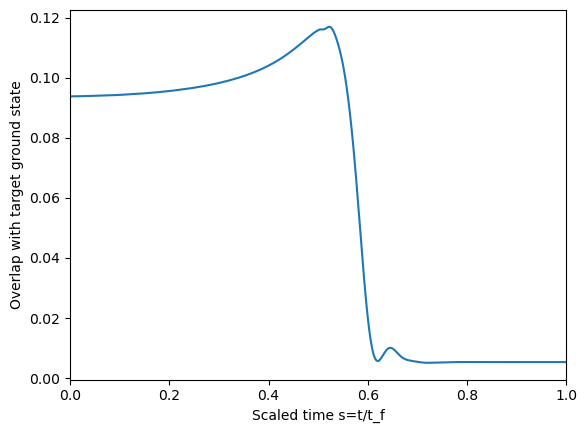

In [72]:
plt.xlim([0, 1])
#plt.ylim([0, 1])
plt.xlabel("Scaled time s=t/t_f")
plt.ylabel("Overlap with target ground state")
x = np.linspace(0, 1, len(overlap))
plt.plot(x, overlap)

In [73]:
#Evolution
t = 0
H = A(t/tf)*physical_Hi + B(t/tf)*physical_Hp2
vap, vep = np.linalg.eigh(H)
psi = vep[:,0]

    
while (t < tf):
        
    H = A(t/tf)*physical_Hi + B(t/tf)*physical_Hp2
            
    psi = CrankNicolson(H, psi, delta_t)
    t += delta_t

In [74]:
degeneracy = len(gs)
vap, vep = np.linalg.eigh(logical_Hp2)
psi_target = []
for i in range(degeneracy):
    psi_target.append(vep[:, i])

target_binary = []
for i in range(len(psi_target)):
    target_binary.append(toBinary(4,psi_target[i]))
    
for i in range(len(psi_target)):
    target_binary[i] = np.insert(target_binary[i], nodes, [target_binary[i][nodes[0]], target_binary[i][nodes[1]]])
    
psi_target_physical = []
for i in range(len(target_binary)):
    psi_target_physical.append(toTensor(6, tuple(target_binary[i])))

In [75]:
print(target_binary)

[array([1, 1, 1, 0, 0, 0]), array([1, 1, 0, 1, 0, 0]), array([1, 1, 0, 0, 1, 1]), array([0, 0, 1, 1, 0, 0]), array([0, 0, 1, 0, 1, 1]), array([0, 0, 0, 1, 1, 1])]


In [76]:
mod = 0
for j in range(degeneracy):
    psi0 = psi_target_physical[j]
    psi0 = np.conjugate(psi0)
    prod = np.dot(psi,psi0)
    aux = (np.real(prod)*np.real(prod) + np.imag(prod)*np.imag(prod))
    print(aux)
    mod += aux

0.00024906840185407787
0.0002490684018541442
0.0021642266516487593
0.0021642266516508483
0.00024906840185408134
0.00024906840185387794


In [77]:
print(mod)

0.005324726910715789


In [61]:
print(psi)

[ 5.91690284e-04-8.14137602e-05j -1.53512148e-06+3.09753196e-06j
 -1.53512148e-06+3.09753196e-06j  3.59720863e-03-4.95572764e-03j
 -3.50041239e-03-3.85202082e-03j  8.19695769e-04+6.42279308e-05j
 -9.19909547e-05-1.70478370e-05j -1.75829282e-01-3.89182947e-01j
 -3.50041239e-03-3.85202082e-03j -9.19909547e-05-1.70478370e-05j
  8.19695769e-04+6.42279308e-05j -1.75829282e-01-3.89182947e-01j
 -2.49816038e-01-2.69629047e-01j  4.12736943e-04-3.56533851e-04j
  4.12736943e-04-3.56533851e-04j  3.59720863e-03-4.95572764e-03j
 -1.53512148e-06+3.09753196e-06j -5.71738883e-06-2.22566977e-05j
 -2.25189031e-06-1.72493563e-06j  4.12736943e-04-3.56533851e-04j
  8.19695769e-04+6.42279308e-05j -1.63749959e-04+1.55298018e-04j
 -1.78421280e-05-7.15478930e-07j  8.19695769e-04+6.42279308e-05j
 -9.19909547e-05-1.70478370e-05j -7.56842415e-06+1.08175949e-05j
 -1.78421280e-05-7.15478925e-07j -9.19909547e-05-1.70478370e-05j
  4.12736943e-04-3.56533851e-04j -5.71738883e-06-2.22566977e-05j
 -2.25189031e-06-1.724935

In [25]:
vap, vep = np.linalg.eigh(H)

In [26]:
#Approximation of the eigenstates
approx_vep = []
for i in range(len(vap)):
    vect = vep[:, i]
    for j in range(len(vect)):
        if (np.abs(vect[j]) < 0.7):
            vect[j] = 0
        else:
            vect[j] = 1
    index = np.where(vect == 1)
    if (len(index[0]) == 1):
        approx_vep.append(vect)

In [27]:
print(len(approx_vep))

28


In [28]:
#Check if chains break
breaks = []
for i in range(len(approx_vep)):
    aux = toBinary(num_physical_qubits, approx_vep[i])
    breaks.append(chainBreak(num_physical_qubits, approx_vep[i], chains))
print(breaks)

[False, False, False, False, False, False, False, False, True, True, True, True, True, False, False, True, True, True, True, True, True, True, True, True, True, True, True, True]


In [29]:
#No chain breaks
for i in range(len(breaks)):
    if (breaks[i] == False):
        aux = physicalToLogical(num_physical_qubits, approx_vep[i], chains)
    
        aux = tuple(aux)
        logical[aux][2] += 1

In [30]:
#Chain breaks
for i in range(len(breaks)):
    if (breaks[i] == True):
        aux = list(toBinary(num_physical_qubits, approx_vep[i]))
  
        fix = 0
        for j in range(len(chains)):
            i1 = chains[j][0] - fix
            aux.pop(i1)
            fix += 1
            
        aux = tuple(aux)
        logical[aux][0] += 1
        logical[aux][2] += 1

In [31]:
print(logical)

defaultdict(<class 'int'>, {(0, 0, 0, 0): [1, 0.0, 2], (0, 0, 0, 1): [1, -0.75, 1], (0, 0, 1, 0): [1, -0.75, 2], (0, 0, 1, 1): [0, -1.0, 1], (0, 1, 0, 0): [2, -0.75, 3], (0, 1, 0, 1): [3, -1.0, 4], (0, 1, 1, 0): [0, -1.0, 1], (0, 1, 1, 1): [1, -0.75, 1], (1, 0, 0, 0): [2, -0.75, 2], (1, 0, 0, 1): [1, -1.0, 2], (1, 0, 1, 0): [0, -1.0, 1], (1, 0, 1, 1): [1, -0.75, 1], (1, 1, 0, 0): [1, -1.0, 2], (1, 1, 0, 1): [2, -0.75, 2], (1, 1, 1, 0): [0, -0.75, 0], (1, 1, 1, 1): [2, 0.0, 3]})


In [32]:
print("state"+ "\t\t" + "chain_break_fraction" + "\t" + "energy" + "\t" + "num_occurrences")
for item in logical:
    if (logical[item][2] != 0):
        fraction = round(logical[item][0]/logical[item][2], 2)
    else:
        fraction = 0.0
    energy = logical[item][1]
    number = logical[item][2]
    print(str(item) + "\t\t" + str(fraction) + "\t\t " + str(energy) + "\t\t" + str(number))

state		chain_break_fraction	energy	num_occurrences
(0, 0, 0, 0)		0.5		 0.0		2
(0, 0, 0, 1)		1.0		 -0.75		1
(0, 0, 1, 0)		0.5		 -0.75		2
(0, 0, 1, 1)		0.0		 -1.0		1
(0, 1, 0, 0)		0.67		 -0.75		3
(0, 1, 0, 1)		0.75		 -1.0		4
(0, 1, 1, 0)		0.0		 -1.0		1
(0, 1, 1, 1)		1.0		 -0.75		1
(1, 0, 0, 0)		1.0		 -0.75		2
(1, 0, 0, 1)		0.5		 -1.0		2
(1, 0, 1, 0)		0.0		 -1.0		1
(1, 0, 1, 1)		1.0		 -0.75		1
(1, 1, 0, 0)		0.5		 -1.0		2
(1, 1, 0, 1)		1.0		 -0.75		2
(1, 1, 1, 0)		0.0		 -0.75		0
(1, 1, 1, 1)		0.67		 0.0		3
